In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
import math
import random
import warnings

## Exploratory Data Analysis of subset FD002
Dataset FD002 contains the sensordata from run-to-failure experiments, simulated using the CMAPSS software. During the entire experiment, only one possible fault could occur. However, each time cycle can happen under any of 6 possible conditions.

### Reading in and transforming the data
I use the pandas library to read the data from the csv into a DataFrame. The sensordata gets min-max normalized. Since the data is sensordata from "run-to-failure" experiments, it's safe to assume the last datapoint of each unit contains the data from the last cycle the unit was active. We can therefore create a RUL-column, counting down to this last cycle.

In [2]:
filepath = '../Data/CMAPSSData/train_FD002.txt'
index_columns = ['unit_nr', 'time_cycles']
setting_columns = ['setting_1', 'setting_2', 'setting_3']
sensor_columns = ['s_{}'.format(i) for i in range(1,22)]
columns = index_columns + setting_columns + sensor_columns
df = pd.read_csv(filepath, sep='\s+', header=None, names=columns)

scaler = MinMaxScaler()
df[sensor_columns] = pd.DataFrame(scaler.fit_transform(df[sensor_columns]))
df[sensor_columns] = 2*df[sensor_columns]-1

df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,-0.879462,-0.636847,-0.377597,-0.453810,-0.706816,...,-0.726367,0.984788,-0.046984,-0.260105,-1.0,-0.354167,0.302326,1.0,-0.687929,-0.681836
1,1,2,41.9982,0.8408,100.0,-1.000000,-0.736306,-0.406799,-0.508930,-1.000000,...,-0.993405,0.984457,0.066026,-0.237185,-1.0,-0.437500,0.255814,1.0,-0.984225,-0.970875
2,1,3,24.9988,0.6218,60.0,-0.523822,-0.967336,-0.929405,-0.886006,-0.413632,...,-0.821940,-0.997685,-0.921407,0.873462,-1.0,-0.875000,-1.000000,-1.0,-0.732510,-0.697172
3,1,4,42.0077,0.8416,100.0,-1.000000,-0.743463,-0.402411,-0.506041,-1.000000,...,-0.991883,0.984182,0.048698,-0.255199,-1.0,-0.458333,0.255814,1.0,-0.971879,-0.947712
4,1,5,25.0005,0.6203,60.0,-0.523822,-0.971741,-0.924258,-0.883695,-0.413632,...,-0.821484,-0.997850,-0.938735,0.875073,-1.0,-0.875000,-1.000000,-1.0,-0.729081,-0.713520


In [3]:
max_cycle = df.groupby(by='unit_nr')['time_cycles'].max()
result_frame = df.merge(max_cycle.to_frame(name='max'), left_on='unit_nr', right_index=True)
df['RUL'] = result_frame['max'] - result_frame['time_cycles']
df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,34.9983,0.8400,100.0,-0.879462,-0.636847,-0.377597,-0.453810,-0.706816,...,0.984788,-0.046984,-0.260105,-1.0,-0.354167,0.302326,1.0,-0.687929,-0.681836,148
1,1,2,41.9982,0.8408,100.0,-1.000000,-0.736306,-0.406799,-0.508930,-1.000000,...,0.984457,0.066026,-0.237185,-1.0,-0.437500,0.255814,1.0,-0.984225,-0.970875,147
2,1,3,24.9988,0.6218,60.0,-0.523822,-0.967336,-0.929405,-0.886006,-0.413632,...,-0.997685,-0.921407,0.873462,-1.0,-0.875000,-1.000000,-1.0,-0.732510,-0.697172,146
3,1,4,42.0077,0.8416,100.0,-1.000000,-0.743463,-0.402411,-0.506041,-1.000000,...,0.984182,0.048698,-0.255199,-1.0,-0.458333,0.255814,1.0,-0.971879,-0.947712,145
4,1,5,25.0005,0.6203,60.0,-0.523822,-0.971741,-0.924258,-0.883695,-0.413632,...,-0.997850,-0.938735,0.875073,-1.0,-0.875000,-1.000000,-1.0,-0.729081,-0.713520,144


### Investigation of the data
As a start, a standard 'describe()' operation is called on the data. This will give a first glance at the statistical properties of the data.

In [4]:
sensor_data = df[sensor_columns]
sensor_data.describe().T

,count,mean,std,min,25%,50%,75%,max
s_1,53759.0,-0.242291,0.716430,-1.0,-1.000000,-0.523822,0.253970,1.0
s_2,53759.0,-0.189973,0.684272,-1.0,-0.742362,-0.624736,0.317736,1.0
s_3,53759.0,-0.045152,0.574002,-1.0,-0.409292,-0.320330,0.385020,1.0
s_4,53759.0,-0.125442,0.573453,-1.0,-0.519159,-0.445819,0.362730,1.0
s_5,53759.0,-0.230255,0.674853,-1.0,-1.000000,-0.413632,0.234360,1.0
s_6,53759.0,-0.259026,0.683245,-1.0,-0.998742,-0.582390,0.230189,1.0
s_7,53759.0,-0.304058,0.696889,-1.0,-0.985037,-0.723832,0.228008,1.0
s_8,53759.0,0.326419,0.613191,-1.0,0.254635,0.301888,0.727925,1.0
s_9,53759.0,-0.122607,0.545991,-1.0,-0.453540,-0.389253,0.288464,1.0
s_10,53759.0,-0.108316,0.689021,-1.0,-0.513514,-0.513514,0.783784,1.0


It's obvious that every column has a large variation, however this might just be because of the different operating conditions.

## Finding the different operating conditions

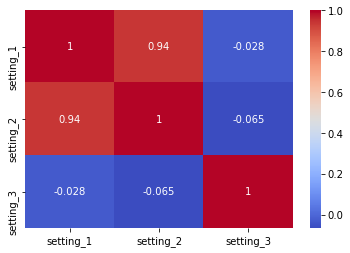

In [10]:
corr_matrix = df[setting_columns].corr()
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.savefig("Images/FD002/Correlation matrix conditions")

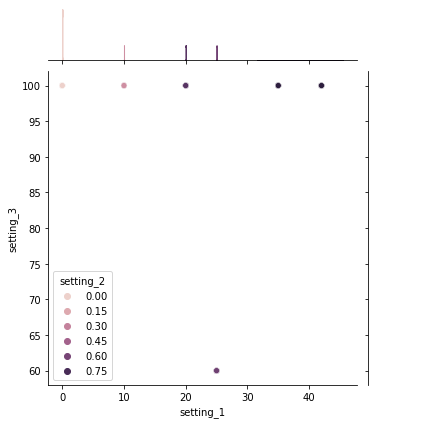

In [16]:
warnings.filterwarnings('ignore')
sns.jointplot(data=df[setting_columns], x='setting_1', y='setting_3', hue='setting_2')
plt.savefig("Images/FD002/jointplot all conditions")

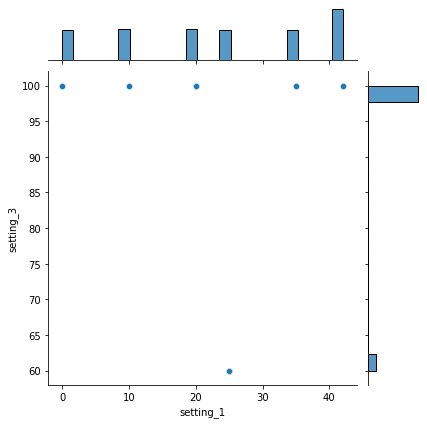

In [17]:
sns.jointplot(data=df[setting_columns], x='setting_1', y='setting_3')
plt.savefig("Images/FD002/jointplot only condition 1 and 3")

### Splitting per condition

In [19]:
conditions = {'35,1,100': 1, '42,1,100': 2, '25,1,60': 3, '20,1,100': 4, '0,0,100': 5, '10,0,100': 6}
condition_list = []
for setting1, setting2, setting3 in df[setting_columns].values:
    key = '{},{},{}'.format(round(setting1), round(setting2), round(setting3))
    condition_list.append(conditions[key])
conditions_df = pd.DataFrame(condition_list, columns=['condition'])
df = df.merge(conditions_df, left_index=True, right_index=True)
df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,condition
0,1,1,34.9983,0.8400,100.0,-0.879462,-0.636847,-0.377597,-0.453810,-0.706816,...,-0.046984,-0.260105,-1.0,-0.354167,0.302326,1.0,-0.687929,-0.681836,148,1
1,1,2,41.9982,0.8408,100.0,-1.000000,-0.736306,-0.406799,-0.508930,-1.000000,...,0.066026,-0.237185,-1.0,-0.437500,0.255814,1.0,-0.984225,-0.970875,147,2
2,1,3,24.9988,0.6218,60.0,-0.523822,-0.967336,-0.929405,-0.886006,-0.413632,...,-0.921407,0.873462,-1.0,-0.875000,-1.000000,-1.0,-0.732510,-0.697172,146,3
3,1,4,42.0077,0.8416,100.0,-1.000000,-0.743463,-0.402411,-0.506041,-1.000000,...,0.048698,-0.255199,-1.0,-0.458333,0.255814,1.0,-0.971879,-0.947712,145,2
4,1,5,25.0005,0.6203,60.0,-0.523822,-0.971741,-0.924258,-0.883695,-0.413632,...,-0.938735,0.875073,-1.0,-0.875000,-1.000000,-1.0,-0.729081,-0.713520,144,3


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

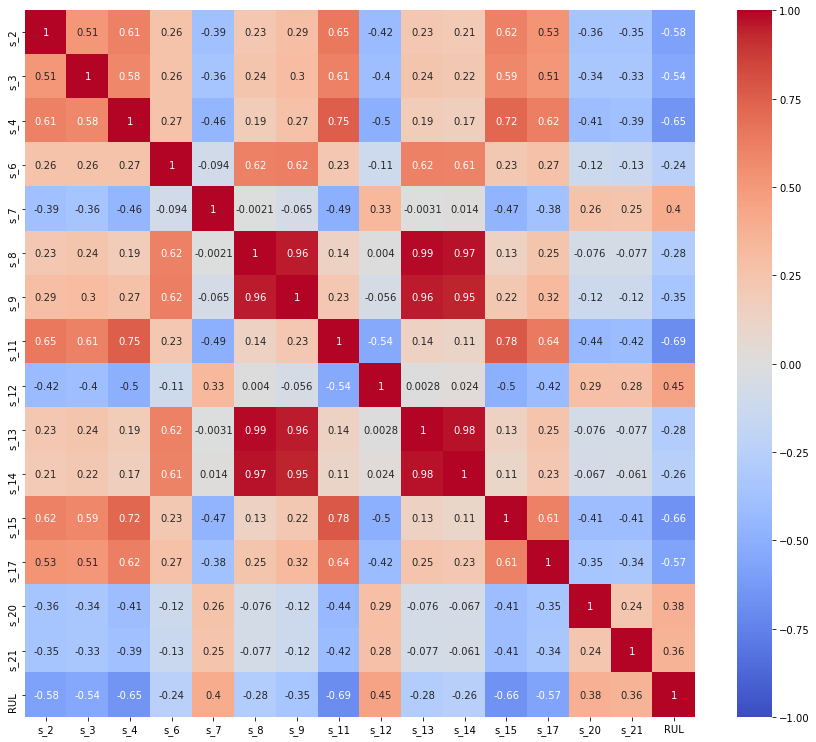

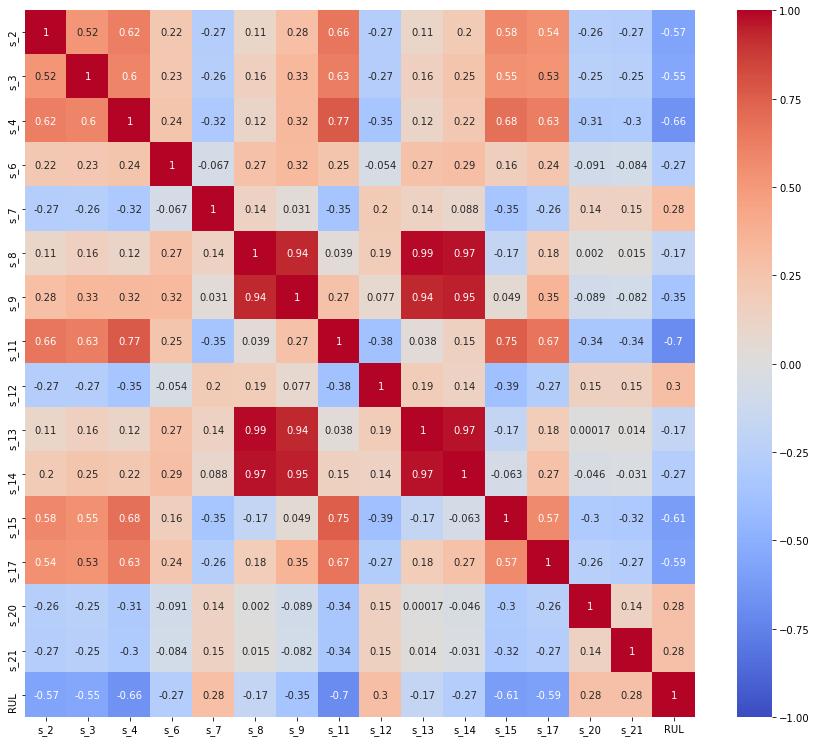

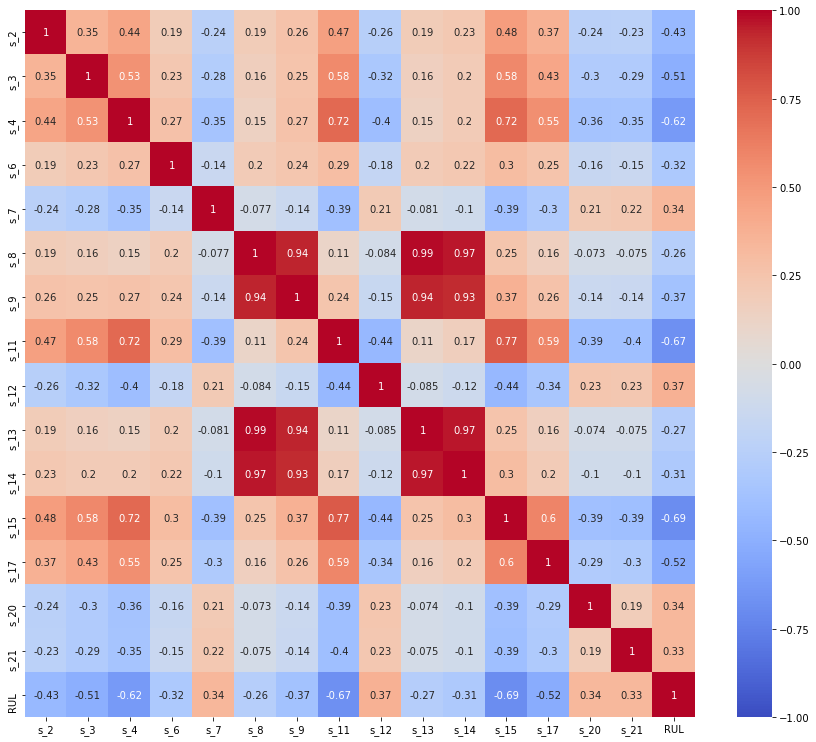

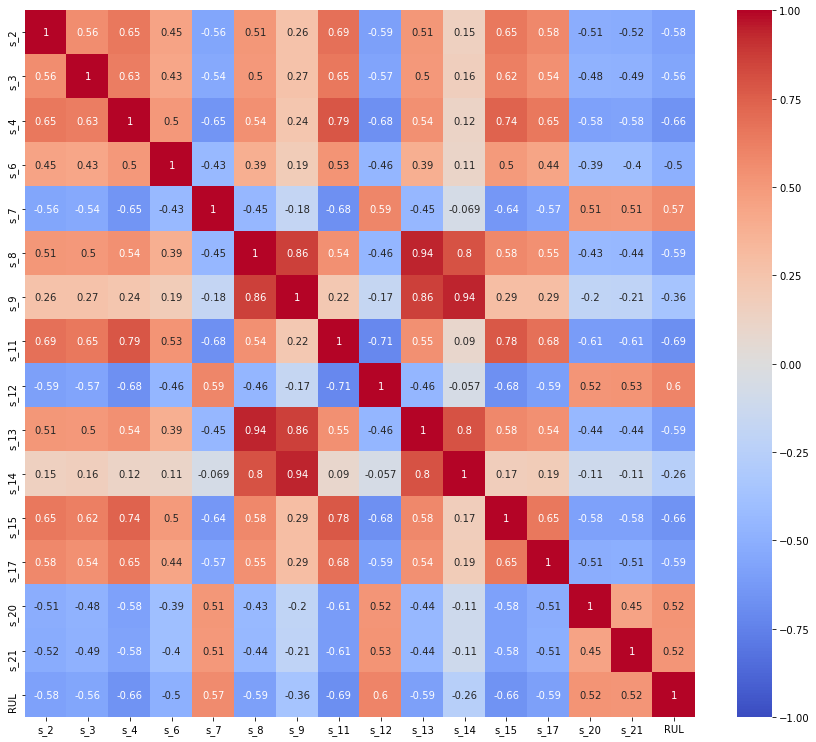

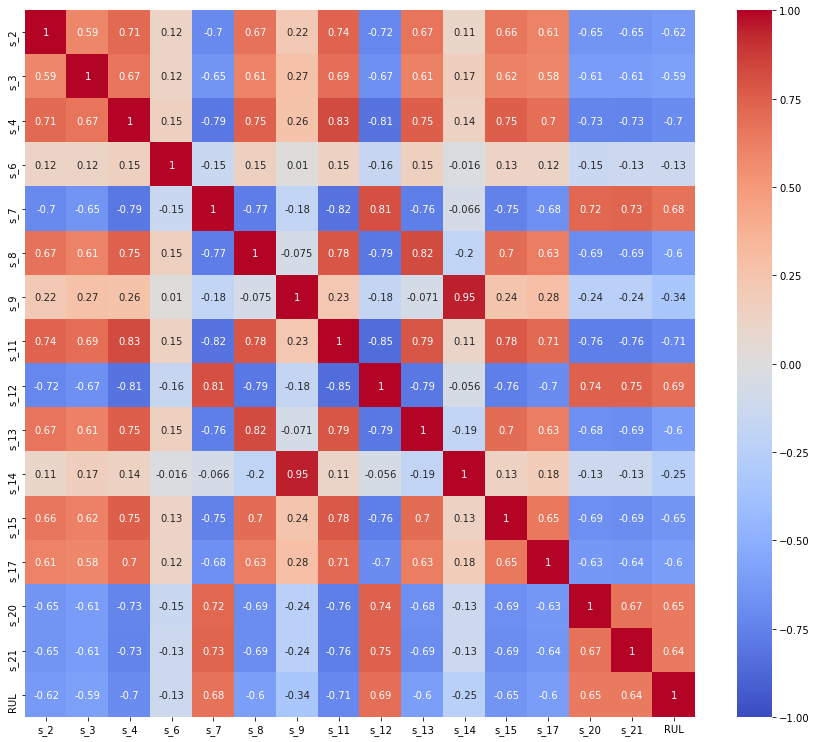

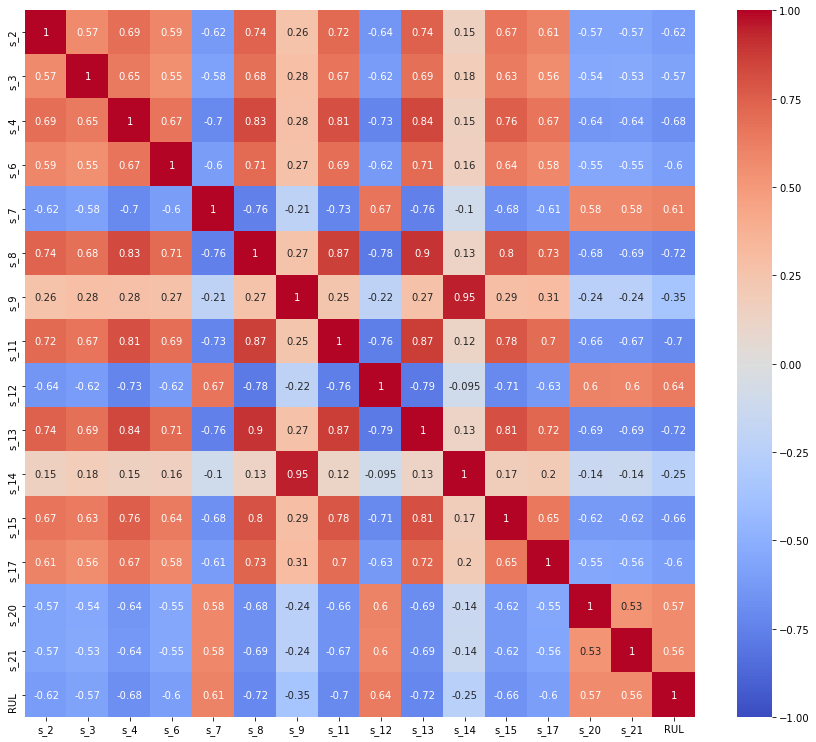

In [27]:
sensor_columns = [sensor for sensor in sensor_columns if sensor not in ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']]
for condition in df['condition'].unique():
    sub_df = df[df['condition'] == condition][sensor_columns + ['RUL']]
    corr_matrix = sub_df.corr()
    plt.figure(figsize=(15,13))
    display(sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm'))
    plt.savefig("Images/FD002/Correlation matrix condition {}".format(condition))